# Polo's Workspace

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()

We load the data

In [2]:
problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()

In [3]:
print('first date: ', min(X_df['DateOfDeparture']))
print('last date: ', max(X_df['DateOfDeparture']))

first date:  2011-09-01
last date:  2013-03-05


In [4]:
X_df.head(10)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159
5,2013-01-22,ATL,MCO,10.363636,8.232025
6,2011-10-20,SFO,LAS,15.266667,9.808277
7,2012-01-28,EWR,ORD,8.588235,6.165010
8,2012-05-27,ATL,CLT,10.238095,6.609877
9,2013-02-22,ATL,DEN,8.294118,5.542616


In [5]:
y_array[:10]

array([12.33129622, 10.77518151, 11.08317675, 11.16926784, 11.26936373,
       12.07364919, 11.17393612,  9.5999524 ,  9.17564514, 10.73431968])

{'whiskers': [<matplotlib.lines.Line2D at 0x1a259f8390>,
 'caps': [<matplotlib.lines.Line2D at 0x1a259f8b00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a259eaef0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a259f8f98>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a25a025c0>],
 'means': []}

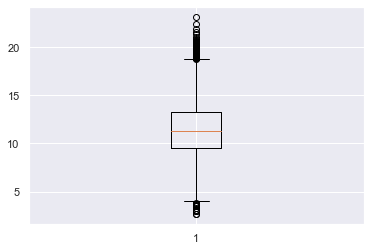

In [13]:
#Boxplot mean
plt.boxplot(X_df.iloc[:, 3])

{'whiskers': [<matplotlib.lines.Line2D at 0x1a2598fb70>,
 'caps': [<matplotlib.lines.Line2D at 0x1a2598fef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a2598f710>],
 'medians': [<matplotlib.lines.Line2D at 0x1a2599ba20>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a2599bda0>],
 'means': []}

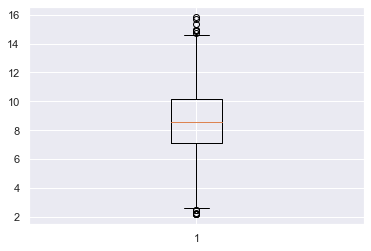

In [12]:
#Boxplot standard deviation
plt.boxplot(X_df.iloc[:, 4])

In [14]:
X_df.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [15]:
X_df['Departure'].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

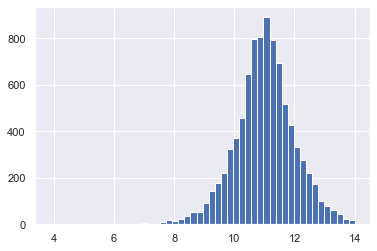

In [16]:
plt.hist(y_array, bins=50);

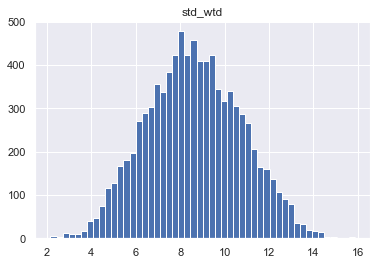

In [17]:
X_df.hist('std_wtd', bins=50);

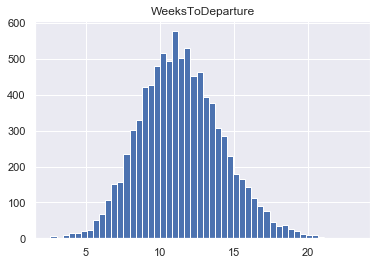

In [18]:
X_df.hist('WeeksToDeparture', bins=50);

In [19]:
print(y_array.mean())
print(y_array.std())

10.99904767212102
0.9938894125318564


## Try with the external data set

In [20]:
X_encoded = X_df
path = os.path.dirname(__file__)
data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
X_weather = X_weather.rename(
            columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
X_encoded = pd.merge(
            X_encoded, X_weather, how='left',
            left_on=['DateOfDeparture', 'Arrival'],
            right_on=['DateOfDeparture', 'Arrival'],
            sort=False)

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
X_encoded = X_encoded.drop('Departure', axis=1)
X_encoded = X_encoded.drop('Arrival', axis=1)

X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

X_encoded = X_encoded.drop(['year', 'month', 'day', 'weekday', 'week', 'n_days'], axis=1)

X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
X_array = X_encoded.values

NameError: name 'os' is not defined